In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from src.structure_io import read_pdb
from src.structure import split_by_chain, atom_select
from sklearn.metrics import roc_auc_score, roc_curve, auc
from structures_store import h5_load_structure

In [2]:
euka_cplx_data = {}
with h5py.File("datasets/eukaryotic_protein_complexes_predictions.h5", 'r') as hf:
    for key in tqdm(hf.keys()):
        hgrp = hf[key]
        euka_cplx_data[key] = [
            np.stack([np.array(hgrp['p0']), np.array(hgrp['y0'])], axis=1),
            np.stack([np.array(hgrp['p1']), np.array(hgrp['y1'])], axis=1),
        ]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 1122.70it/s]


In [3]:
afs_cplx_data = {}
for cid in tqdm(euka_cplx_data):
    pdb_filepath = 'eukaryotic_protein_complexes/ma-bak-cepc-{}.pdb'.format(cid)

    cplx = read_pdb(pdb_filepath)
    cplx_ca = atom_select(cplx, cplx['name'] == 'CA')

    subunits_ca = split_by_chain(cplx_ca)

    afs0 = subunits_ca['A:0']['bfactor']
    afs1 = subunits_ca['B:0']['bfactor']
    
    afs_cplx_data[cid] = [afs0, afs1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [01:39<00:00, 11.03it/s]


## ROC AUC

In [4]:
# compute ROC AUC using predicted complexes as reference
aucs_all = []
for cid in tqdm(euka_cplx_data):
    P0, P1 = euka_cplx_data[cid]
    aucs_all.append([roc_auc_score(P0[:,1], P0[:,0]), roc_auc_score(P1[:,1], P1[:,0])])
aucs_all = np.array(aucs_all)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:01<00:00, 782.72it/s]


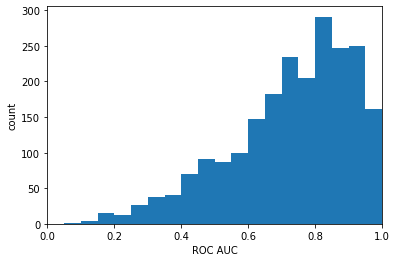

(0.7287790770374221, 0.7630708596468034)

In [5]:
# plot
plt.figure()
plt.hist(aucs_all.ravel(), range=(0.0,1.0), bins=20)
plt.xlim(0.0, 1.0)
plt.xlabel('ROC AUC')
plt.ylabel('count')
plt.show()

# debug print
np.mean(aucs_all.ravel()), np.median(aucs_all.ravel())

## ROC AUC structured regions

In [6]:
# parameters
afs_thr = 70.0

# compute ROC AUC using predicted complexes as reference
aucs_str = []
for cid in tqdm(euka_cplx_data):
    P0, P1 = euka_cplx_data[cid]
    afs0, afs1 = afs_cplx_data[cid]
    P0 = P0[afs0 > afs_thr]
    P1 = P1[afs1 > afs_thr]
    if (np.min(P0[:,1]) < np.max(P0[:,1])) and (np.min(P1[:,1]) < np.max(P1[:,1])):
        aucs_str.append([roc_auc_score(P0[:,1], P0[:,0]), roc_auc_score(P1[:,1], P1[:,0])])

aucs_str = np.array(aucs_str)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:01<00:00, 792.28it/s]


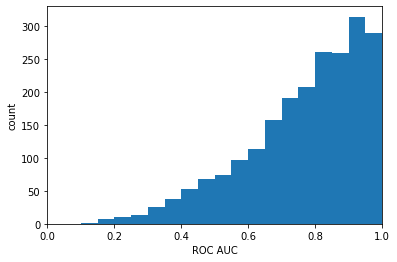

(0.7671635717099454, 0.8065209192867723)

In [7]:
# plot
plt.figure()
plt.hist(aucs_str.ravel(), range=(0.0,1.0), bins=20)
plt.xlim(0.0, 1.0)
plt.xlabel('ROC AUC')
plt.ylabel('count')
plt.show()

# debug print
np.mean(aucs_str.ravel()), np.median(aucs_str.ravel())

In [8]:
# parameters
afs_thr_l = [0.0, 50.0, 70.0, 90.0]

fpr_l, tpr_l = [], []
for afs_thr in afs_thr_l:
    # compute ROC AUC using predicted complexes as reference
    P_all = []
    m_l = []
    for cid in euka_cplx_data:
        P0, P1 = euka_cplx_data[cid]
        afs0, afs1 = afs_cplx_data[cid]
        P0 = P0[afs0 > afs_thr]
        P1 = P1[afs1 > afs_thr]
        #P0 = P0*(afs0 > afs_thr).astype(float).reshape(-1,1)
        #P1 = P1*(afs1 > afs_thr).astype(float).reshape(-1,1)
        P_all.append(P0)
        P_all.append(P1)
        m_l.append(afs0 > afs_thr)
        m_l.append(afs1 > afs_thr)

    P_all = np.concatenate(P_all)
    fpr, tpr, _ = roc_curve(P_all[:,1], P_all[:,0])
    fpr_l.append(fpr)
    tpr_l.append(tpr)
    r_str = np.mean(np.concatenate(m_l))
    print(afs_thr, r_str*1e2)

0.0 100.0
50.0 81.76013922732439
70.0 70.98945883358499
90.0 37.426225351061134


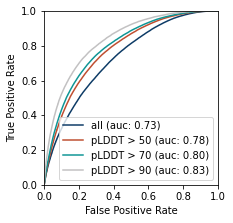

In [9]:
colors = ['#0d3b66', '#bf4e30', '#0e9595', '#c2c1c2', '#dbad6a']
labels = ["all", "pLDDT > 50", "pLDDT > 70", "pLDDT > 90"]

plt.figure(figsize=(3.3,3.2))
for i in range(len(labels)):
    auci = auc(fpr_l[i], tpr_l[i])
    plt.plot(fpr_l[i], tpr_l[i], label="{} (auc: {:.2f})".format(labels[i], auci), color=colors[i])
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.savefig("results/eukaryotic_protein_complexes_predictions_roc.png", dpi=300)
plt.savefig("results/eukaryotic_protein_complexes_predictions_roc.svg")
plt.show()

## Filter out by PAE

In [10]:
# map to uniprot
df = pd.read_html("eukaryotic_protein_complexes/eukaryotic_protein_complexes.html")[0]
uniprot_ids = np.stack([df[i+1].str.replace('.*; ','').values for i in range(2)], -1)
uniprots_avail = np.unique(uniprot_ids.ravel())

# filter available uniprot
npy_filepaths = glob("alphafold_pae/**/*.npy", recursive=True)
npy_filepaths = [fp for fp in npy_filepaths if fp.split('/')[-1].split('-')[1] in uniprots_avail]

structures = {}
with h5py.File("datasets/models.h5", 'r') as hf:
    keys = np.array(hf['metadata/keys']).astype(np.dtype('U'))
    for key in tqdm(np.array([k for k in keys if k.split('/')[1] in uniprots_avail])):
        structures[key.split('/')[1]] = h5_load_structure(hf[key])

/tmp/ipykernel_455385/4144506184.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  uniprot_ids = np.stack([df[i+1].str.replace('.*; ','').values for i in range(2)], -1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1239/1239 [00:07<00:00, 170.60it/s]


In [11]:
# parameters
afs_thr = 90.0

msPAE = {}
for npy_filepath in tqdm(npy_filepaths):
    uniprot = npy_filepath.split('/')[-1].split('-')[1]
    if (uniprot in structures):
        afs = structures[uniprot]['bfactor'][structures[uniprot]['name'] == "CA"]
        D = np.load(npy_filepath).astype(np.float32)

        m_afs = (afs > afs_thr)
        Ds = D[m_afs,:][:,m_afs]
        if Ds.shape[0] > 0:
            msPAE[uniprot] = (np.mean(Ds), Ds.shape[0] / afs.shape[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1239/1239 [00:02<00:00, 423.57it/s]


In [12]:
# parameters
min_ratio_size = 0.7
max_mean_pae = 10.0

# filter uniprots
m_sel = ((pd.DataFrame(msPAE).T.values[:,0] < max_mean_pae) & (pd.DataFrame(msPAE).T.values[:,1] < min_ratio_size))
uniprots_sel = np.array(list(msPAE))[m_sel]
ids_sel, ids_sub = np.where(np.isin(uniprot_ids, uniprots_sel))

P_all = []
for i,j in zip(ids_sel, ids_sub):
    cid = "{:04d}".format(i+1)
    if cid in euka_cplx_data:
        P = euka_cplx_data[cid][ids_sub[j]]
        afs = afs_cplx_data[cid][ids_sub[j]]
        P = P[afs > afs_thr]
        P_all.append(P)

P_all = np.concatenate(P_all)
fpr, tpr, _ = roc_curve(P_all[:,1], P_all[:,0])
aucq = auc(fpr, tpr)
aucq, np.mean(m_sel)*1e2

(0.8448510353136394, 59.06095551894563)

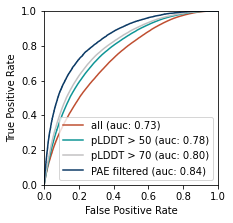

In [13]:
colors = ['#0d3b66', '#bf4e30', '#0e9595', '#c2c1c2', '#dbad6a']
labels = ["all", "pLDDT > 50", "pLDDT > 70"]

plt.figure(figsize=(3.3,3.2))
for i in range(len(labels)):
    auci = auc(fpr_l[i], tpr_l[i])
    plt.plot(fpr_l[i], tpr_l[i], label="{} (auc: {:.2f})".format(labels[i], auci), color=colors[i+1])
plt.plot(fpr, tpr, label="PAE filtered (auc: {:.2f})".format(aucq), color=colors[0])
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
#plt.savefig("results/eukaryotic_protein_complexes_predictions_roc_fpae.png", dpi=300)
#plt.savefig("results/eukaryotic_protein_complexes_predictions_roc_fpae.svg")
plt.show()

## Overlap

In [14]:
def overlap(P):
    u = np.max(P, axis=1)
    n = P[:,0] * P[:,1]
    return np.sum(n) / np.sum(u)

In [15]:
overlaps = []
for cid in tqdm(euka_cplx_data):
    P0, P1 = euka_cplx_data[cid]
    Q0 = np.round(P0)
    Q1 = np.round(P1)

    overlaps.append([overlap(Q0), overlap(Q1)])

overlaps = np.array(overlaps)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 19332.55it/s]


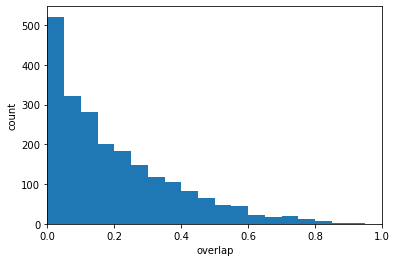

(0.19911379992973502, 0.14660919540229883)

In [16]:
plt.figure()
plt.hist(overlaps.ravel(), range=(0.0,1.0), bins=20)
plt.xlim(0.0,1.0)
plt.xlabel('overlap')
plt.ylabel('count')
plt.show()

# debug print
np.mean(overlaps.ravel()), np.median(overlaps.ravel())

In [17]:
# parameters
afs_thr = 70.0

overlaps = []
for cid in tqdm(euka_cplx_data):
    P0, P1 = euka_cplx_data[cid]
    afs0, afs1 = afs_cplx_data[cid]
    Q0 = np.round(P0)[afs0 > afs_thr]
    Q1 = np.round(P1)[afs1 > afs_thr]

    overlaps.append([overlap(Q0), overlap(Q1)])

overlaps = np.array(overlaps)

  0%|                                                                                                                                                                                       | 0/1102 [00:00<?, ?it/s]/tmp/ipykernel_455385/2464575273.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(n) / np.sum(u)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 9480.83it/s]


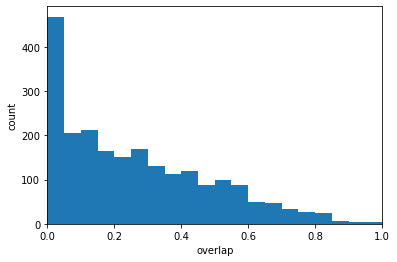

(0.2614600854556923, 0.21428571428571427)

In [18]:
plt.figure()
plt.hist(overlaps.ravel(), range=(0.0,1.0), bins=20)
plt.xlim(0.0,1.0)
plt.xlabel('overlap')
plt.ylabel('count')
plt.show()

# debug print
np.nanmean(overlaps.ravel()), np.nanmedian(overlaps.ravel())

## Interface quality assessment

In [19]:
z_l = []
for cid in tqdm(afs_cplx_data):
    py0, py1 = euka_cplx_data[cid]
    q0, q1 = afs_cplx_data[cid]
    z_l.append(np.concatenate([py0, q0.reshape(-1,1)], axis=1))
    z_l.append(np.concatenate([py1, q1.reshape(-1,1)], axis=1))

Z = np.concatenate(z_l)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 103563.06it/s]


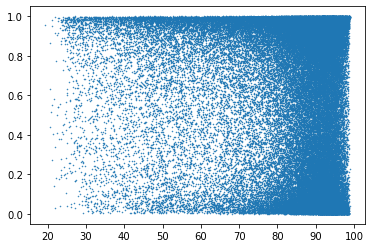

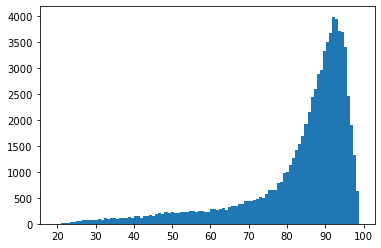

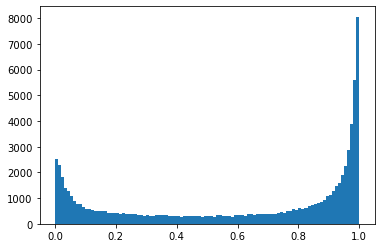

In [20]:
m = (Z[:,1] > 0.5)
x = Z[m,2]
y = Z[m,0]

plt.figure()
plt.plot(x, y, '.', ms=1.0)
plt.show()

plt.figure()
plt.hist(x, bins=100)
plt.show()

plt.figure()
plt.hist(y, bins=100)
plt.show()

In [21]:
cids = np.array(list(afs_cplx_data))
cids

array(['0001', '0002', '0003', ..., '1104', '1105', '1106'], dtype='<U4')

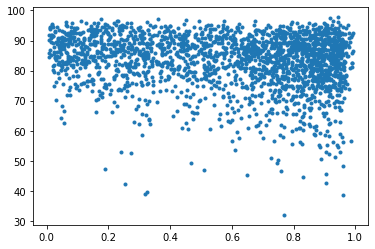

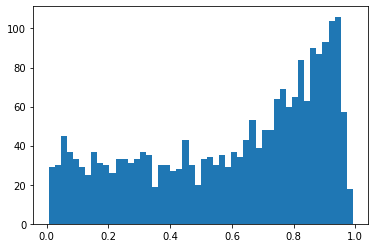

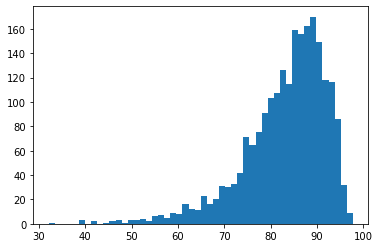

In [22]:
mz = np.array([[np.mean(z[z[:,1] > 0.5,0]), np.mean(z[z[:,1] > 0.5,2])] for z in z_l])

x = mz[:,0]
y = mz[:,1]

plt.figure()
plt.plot(x, y, '.')
plt.show()

plt.figure()
plt.hist(x, bins=50)
plt.show()

plt.figure()
plt.hist(y, bins=50)
plt.show()

In [23]:
# parameters
afs_thr = 70.0

# compute ROC AUC using predicted complexes as reference
aucs_l, afs_l, mp_l, cids_l = [], [], [], []
for cid in tqdm(afs_cplx_data):
    py0, py1 = euka_cplx_data[cid]
    afs0, afs1 = afs_cplx_data[cid]
    py0i = py0[afs0 > afs_thr]
    py1i = py1[afs1 > afs_thr]
    if (np.min(py0i[:,1]) < np.max(py0i[:,1])) and (np.min(py1i[:,1]) < np.max(py1i[:,1])):
        aucs_l.append([roc_auc_score(py0i[:,1], py0i[:,0]), roc_auc_score(py1i[:,1], py1i[:,0])])
        afs_l.append([np.mean(afs0[py0[:,1] > 0.5]), np.mean(afs1[py1[:,1] > 0.5])])
        mp_l.append([np.mean(py0[py0[:,1] > 0.5,0]), np.mean(py1[py1[:,1] > 0.5,0])])
        cids_l.append(cid)

aucs = np.array(aucs_l)
afs = np.array(afs_l)
mp = np.array(mp_l)
cids = np.array(cids_l)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:01<00:00, 756.80it/s]


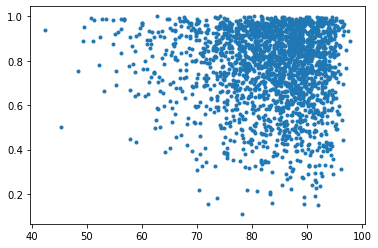

In [24]:
x = afs.ravel()
y = aucs.ravel()

plt.figure()
plt.plot(x,y,'.')
plt.show()

### Save summary table

In [25]:
# map to uniprot
df = pd.read_html("eukaryotic_protein_complexes/eukaryotic_protein_complexes.html")[0]
uniprot_ids = np.stack([df[i+1].str.replace('.*; ','').values for i in range(2)], -1)
dfc = pd.DataFrame({'cid': np.array(["{:04d}".format(i+1) for i in range(df.shape[0])]), 'uniprot1':uniprot_ids[:,0], 'uniprot2':uniprot_ids[:,1]})
dfc

/tmp/ipykernel_455385/2150279384.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  uniprot_ids = np.stack([df[i+1].str.replace('.*; ','').values for i in range(2)], -1)


,cid,uniprot1,uniprot2
0,0001,A6ZM67,P38129
1,0002,A6ZM67,Q05027
2,0003,A6ZMA9,Q08235
3,0004,A6ZMI6,Q06537
4,0005,A6ZMR2,P33336
...,...,...,...
1101,1102,Q99257,P34232
1102,1103,Q99278,P32569
1103,1104,Q99278,P32570
1104,1105,Q99380,P39007


In [26]:
dfs = pd.DataFrame({
    'cid': cids,
    'auc1': aucs[:,0].round(2), 'auc2': aucs[:,1].round(2),
    'mafs_int1': afs[:,0].round(1), 'mafs_int2': afs[:,1].round(1),
    'mp_int1': mp[:,0].round(2), 'mp_int2': mp[:,1].round(2),
})
dfs['mauc'] = np.sqrt(dfs['auc1']*dfs['auc2']).round(2)
dfs['mp_int'] = np.sqrt(dfs['mp_int1']*dfs['mp_int2']).round(2)
dfs['mafs_int'] = 0.5*(dfs['mafs_int1']+dfs['mafs_int2']).round(1)
dfs = pd.merge(dfc, dfs, on='cid').sort_values('mauc')
dfs.to_csv("eukaryotic_protein_complexes_scoring.csv", index=False)
dfs

,cid,uniprot1,uniprot2,auc1,auc2,mafs_int1,mafs_int2,mp_int1,mp_int2,mauc,mp_int,mafs_int
414,0421,P36531,P36527,0.53,0.11,85.8,78.1,0.67,0.39,0.24,0.51,81.95
679,0688,P53062,P38770,0.24,0.27,91.0,89.3,0.09,0.27,0.25,0.16,90.15
1065,1083,Q3E731,Q02771,0.33,0.22,70.9,79.1,0.51,0.41,0.27,0.46,75.00
346,0350,P33759,P40496,0.19,0.39,91.4,88.2,0.02,0.47,0.27,0.10,89.80
834,0846,Q03281,P47048,0.33,0.26,90.4,91.6,0.05,0.02,0.29,0.03,91.00
...,...,...,...,...,...,...,...,...,...,...,...,...
851,0864,Q03630,Q03784,0.97,1.00,82.5,79.2,0.79,0.89,0.98,0.84,80.85
324,0328,P32913,Q92331,1.00,0.98,85.7,94.0,0.93,0.88,0.99,0.90,89.85
1088,1106,Q9URQ3,P47058,0.99,0.99,92.4,92.6,0.84,0.89,0.99,0.86,92.50
731,0740,P53731,P33204,1.00,1.00,90.4,91.8,0.81,0.89,1.00,0.85,91.10


In [27]:
auc_thr = 0.8

r11 = np.mean((dfs['auc1'].values >= auc_thr) & (dfs['auc2'].values >= auc_thr))
r10 = np.mean((dfs['auc1'].values >= auc_thr) & (dfs['auc2'].values < auc_thr))
r01 = np.mean((dfs['auc1'].values < auc_thr) & (dfs['auc2'].values >= auc_thr))
r00 = np.mean((dfs['auc1'].values < auc_thr) & (dfs['auc2'].values < auc_thr))

In [28]:
r11, r10+r01, r00

(0.29935720844811753, 0.45179063360881544, 0.24885215794306703)

In [29]:
np.mean(np.concatenate([dfs['auc1'].values >= auc_thr, dfs['auc2'].values >= auc_thr]))

0.5252525252525253